# Requirements

In [ ]:
!pip install keras
!pip install keras_preprocessing
!pip install tensorflow
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00


# Libraries

In [ ]:
# Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# System Libraries
import os
import random
import os.path
from pathlib import Path
import pandas as pd

# Visualization Libraries
import cv2
import seaborn as sns
import matplotlib.cm as cm
from PIL import Image, ImageChops, ImageEnhance

# Torch Libraroes
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset

# Metrics
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

# Model
from tensorflow.keras.applications import MobileNetV2,ResNet50, ResNet50V2

# Extra
from termcolor import colored
#from google.colab import drive
import zipfile

# Data

## Global Variable

In [ ]:
PATH = '/kaggle/input/deepfakesss/similar'
PATH_styletransfer = '/kaggle/input/deepfakesss/similar/style_transfer'
PATH_inpainting = '/kaggle/input/deepfakesss/similar/inpainting'
PATH_old = '/kaggle/input/dataset'
images = []
class_list = []
labels_class = ['Original', 'AI Generated']
labels_class

['Original', 'AI Generated']

## Load Image

### Load Inpainting

In [ ]:
import shutil
import random

# Directories
source_directory = '/kaggle/input/deepfakesss/similar/inpainting'
target_directory = '/kaggle/working/organized_dataset'  # Save in Kaggle's working directory
original_dir = os.path.join(target_directory, "Original")
ai_generated_dir = os.path.join(target_directory, "AI_Generated")

# Create target directories if they don't exist
os.makedirs(original_dir, exist_ok=True)
os.makedirs(ai_generated_dir, exist_ok=True)

# Limits
class_0_count = 0
class_1_count = 0
max_images_per_class = 750

# Shuffle folders in the source directory
folders = os.listdir(source_directory)
random.shuffle(folders)

# Process each folder
for folder_name in folders:
    class_path = os.path.join(source_directory, folder_name)

    # Skip if not a directory
    if not os.path.isdir(class_path):
        continue

    # Iterate over files in the current folder
    for file_name in os.listdir(class_path):
        if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
            break  # Stop if both classes have reached the limit

        file_path = os.path.join(class_path, file_name)

        # Check and copy files based on their names
        if file_name == 'original.png' and class_0_count < max_images_per_class:
            new_file_name = f"{folder_name}_original_{class_0_count + 1}.png"
            shutil.copy(file_path, os.path.join(original_dir, new_file_name))
            class_0_count += 1
        elif file_name == 'inpainting.png' and class_1_count < max_images_per_class:
            new_file_name = f"{folder_name}_ai_generated_{class_1_count + 1}.png"
            shutil.copy(file_path, os.path.join(ai_generated_dir, new_file_name))
            class_1_count += 1

    # Stop outer loop if both limits are reached
    if class_0_count >= max_images_per_class and class_1_count >= max_images_per_class:
        break

print(f"Original images: {class_0_count}")
print(f"AI Generated images: {class_1_count}")

Original images: 750
AI Generated images: 750


### Loashutile Transfer

In [ ]:
import shutil
import hashlib
# Constants
max_images_per_folder = 40
max_per_class_per_folder = 20

# Global counters for both classes
class_0_count = 0
class_1_count = 0

# Get a list of folders and shuffle them
folders = os.listdir(PATH_styletransfer)
random.shuffle(folders)

# Iterate through each shuffled folder
for class_name in folders:
    class_path = os.path.join(PATH_styletransfer, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    # Per-folder counters
    folder_class_0_count = 0
    folder_class_1_count = 0

    # Get a list of files in the current folder and shuffle them
    files = os.listdir(class_path)
    random.shuffle(files)

    for file in files:
        # Stop per-folder if max images per class have been processed
        if folder_class_0_count >= max_per_class_per_folder and folder_class_1_count >= max_per_class_per_folder:
            break

        file_path = os.path.join(class_path, file)

        # Generate a unique hash for the file path
        unique_hash = hashlib.md5(file_path.encode()).hexdigest()[:8]

        # Process "*_original.png" images
        if file.endswith("original.png") and folder_class_0_count < max_per_class_per_folder:
            global_file_name = f"{class_name}_original_{class_0_count + 1}_{unique_hash}.png"
            shutil.copy(file_path, os.path.join(original_dir, global_file_name))
            folder_class_0_count += 1
            class_0_count += 1

        # Process "*_generated.png" images
        elif file.endswith("generated.png") and folder_class_1_count < max_per_class_per_folder:
            global_file_name = f"{class_name}_ai_generated_{class_1_count + 1}_{unique_hash}.png"
            shutil.copy(file_path, os.path.join(ai_generated_dir, global_file_name))
            folder_class_1_count += 1
            class_1_count += 1

# Final results
print(f"Total Original images copied: {class_0_count}")
print(f"Total AI Generated images copied: {class_1_count}")


Total Original images copied: 540
Total AI Generated images copied: 540


# Old Dataset

In [ ]:
# Constants
images_per_folder = 60
ai_prefix = "AI_"

# Global counters
class_0_count = 0  # Human drawn images
class_1_count = 0  # AI-generated images

# Traverse the style_transfer directory
for class_name in os.listdir(PATH_old):
    class_path = os.path.join(PATH_old, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-directory files

    # Determine class based on folder name
    is_ai_generated = class_name.startswith(ai_prefix)

    # Reset per-folder counter
    folder_image_count = 0

    # Shuffle files to ensure randomness
    files = os.listdir(class_path)
    random.shuffle(files)

    for file in files:
        if folder_image_count >= images_per_folder:
            break  # Stop after 30 images for this folder

        file_path = os.path.join(class_path, file)

        # Generate a unique hash for the file path
        unique_hash = hashlib.md5(file_path.encode()).hexdigest()[:8]

        if is_ai_generated:
            # For AI-generated folders
            new_file_name = f"{class_name}_ai_generated_{folder_image_count + 1}_{unique_hash}.jpg"
            shutil.copy(file_path, os.path.join(ai_generated_dir, new_file_name))
            class_1_count += 1
        else:
            # For Human-drawn folders
            new_file_name = f"{class_name}_human_drawn_{folder_image_count + 1}_{unique_hash}.jpg"
            shutil.copy(file_path, os.path.join(original_dir, new_file_name))
            class_0_count += 1

        folder_image_count += 1

# Final counts
print(f"Total Human Drawn images: {class_0_count}")
print(f"Total AI Generated images: {class_1_count}")

Total Human Drawn images: 540
Total AI Generated images: 540


## Image Distribution

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


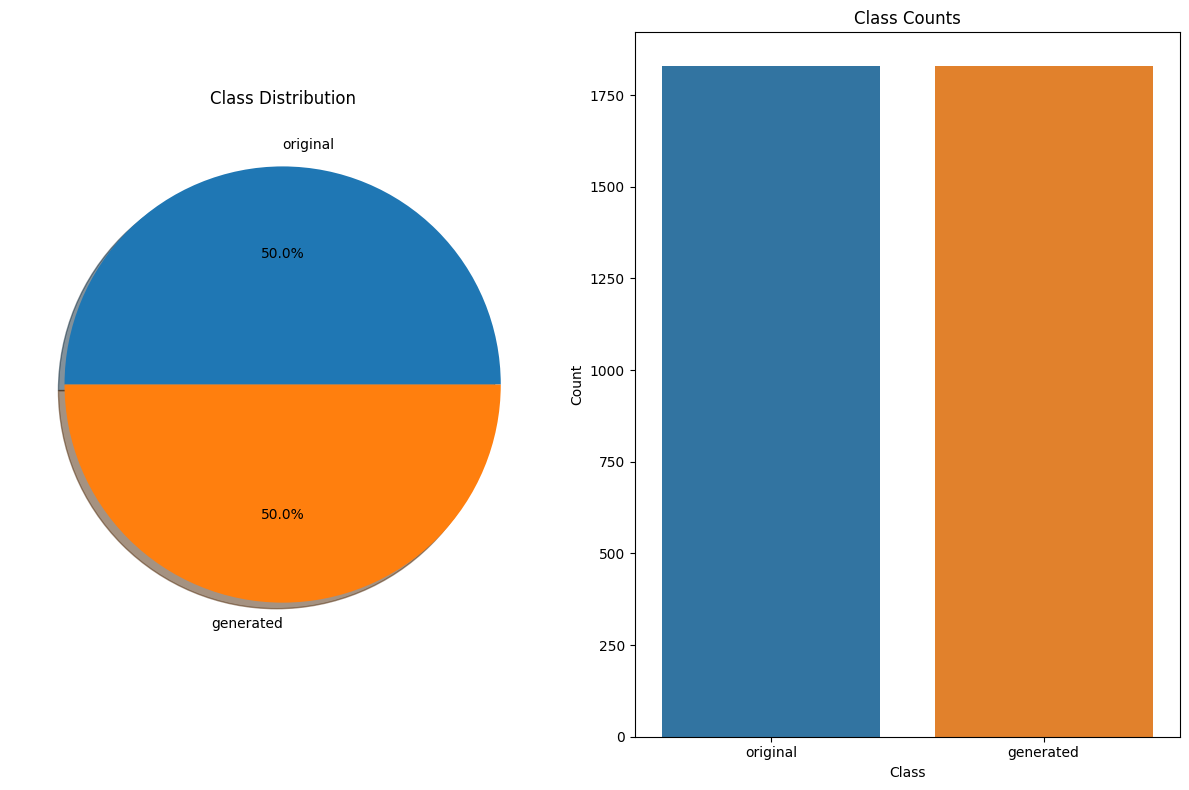

In [ ]:
import seaborn as sns
class_counts = {
    'original': len(os.listdir(original_dir)),
    'generated': len(os.listdir(ai_generated_dir))
}

# Convert to pandas Series for visualization
class_series = pd.Series(class_counts)

# Plot the distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# Pie chart
class_series.plot(kind='pie', ax=ax[0], autopct='%1.1f%%', shadow=True)
ax[0].set_title('Class Distribution')
ax[0].set_ylabel('')  # Hide y-axis label

# Bar chart
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), ax=ax[1])
ax[1].set_title('Class Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# Data Processing

## Define Transformer

In [ ]:
transform = transforms.Compose([
    transforms.Resize((240, 240)),                      # Resize to larger size for cropping
    transforms.RandomHorizontalFlip(p=0.5),            # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),              # Random vertical flip
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2)], p=0.5),  # Random brightness
    transforms.RandomApply([transforms.ColorJitter(contrast=0.2)], p=0.5),    # Random contrast
    transforms.RandomCrop((224, 224)),                 # Crop back to target size
    transforms.ToTensor(),                             # Convert image to tensor
])

# For validation and test
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to fixed size
    transforms.ToTensor(),          # Convert to tensor
])

## Custom Class Dataset

In [ ]:
full_dataset = datasets.ImageFolder(root='/kaggle/working/organized_dataset')

In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate lengths for each split
train_len = int(train_ratio * len(full_dataset))
val_len = int(val_ratio * len(full_dataset))
test_len = len(full_dataset) - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_len, val_len, test_len])

train_dataset.dataset.transform = transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training set size: {len(train_dataset)}')
print(f'Validation set size: {len(val_dataset)}')
print(f'Test set size: {len(test_dataset)}')

Training set size: 2928
Validation set size: 366
Test set size: 366


In [ ]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor

num_classes = 2
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch.nn as nn
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Adjust learning rate as needed
criterion = nn.CrossEntropyLoss()

In [ ]:
import torch

# Training and validation loop
epochs = 30  # Number of epochs
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    # ---- Training Phase ----
    model.train()  # Set model to training mode
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in train_loader:
        inputs, labels = batch[0].to(device), batch[1].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Check if outputs are in the expected format
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits  # Extract logits if necessary

        # Calculate loss
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train if total_train > 0 else 0

    # ---- Validation Phase ----
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(inputs)
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits  # Extract logits if necessary

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_accuracy = correct_val / total_val if total_val > 0 else 0

    # Store losses and accuracies
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print the metrics for each epoch
    print(f"Epoch {epoch + 1}/{epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")


Epoch 1/30, Train Loss: 0.6154, Train Accuracy: 0.6609, Val Loss: 0.5311, Val Accuracy: 0.7514
Epoch 2/30, Train Loss: 0.3881, Train Accuracy: 0.8470, Val Loss: 0.4455, Val Accuracy: 0.7842
Epoch 3/30, Train Loss: 0.2540, Train Accuracy: 0.9153, Val Loss: 0.4036, Val Accuracy: 0.8060
Epoch 4/30, Train Loss: 0.1511, Train Accuracy: 0.9631, Val Loss: 0.3916, Val Accuracy: 0.8361
Epoch 5/30, Train Loss: 0.0816, Train Accuracy: 0.9891, Val Loss: 0.3960, Val Accuracy: 0.8279
Epoch 6/30, Train Loss: 0.0409, Train Accuracy: 0.9966, Val Loss: 0.3979, Val Accuracy: 0.8415
Epoch 7/30, Train Loss: 0.0215, Train Accuracy: 0.9990, Val Loss: 0.4381, Val Accuracy: 0.8443
Epoch 8/30, Train Loss: 0.0118, Train Accuracy: 0.9997, Val Loss: 0.4931, Val Accuracy: 0.8333
Epoch 9/30, Train Loss: 0.0076, Train Accuracy: 1.0000, Val Loss: 0.5032, Val Accuracy: 0.8306
Epoch 10/30, Train Loss: 0.0050, Train Accuracy: 1.0000, Val Loss: 0.5317, Val Accuracy: 0.8388
Epoch 11/30, Train Loss: 0.0036, Train Accuracy: 

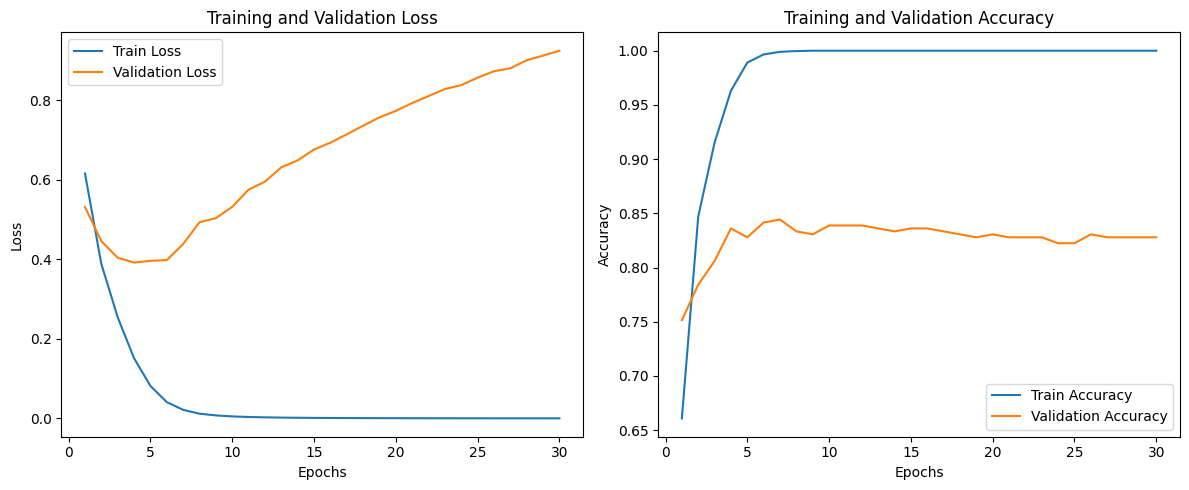

In [ ]:
epochs_range = range(1, epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the fine-tuned model on the test set
model.eval()
predictions = []
true_labels = []
for batch in test_loader:
    batch = tuple(t.to(device) for t in batch)
    inputs, labels = batch
    with torch.no_grad():
        outputs = model(inputs)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(predicted_labels)
    true_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
accuracy = accuracy_score(true_labels, predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.8114754098360656


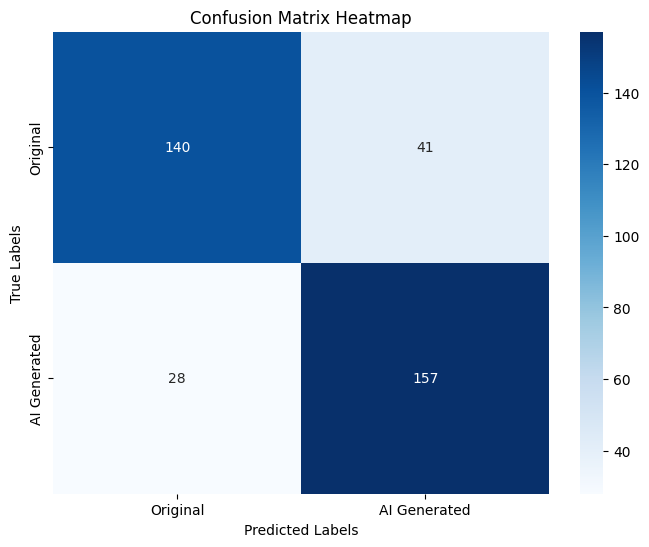

In [ ]:
cm = confusion_matrix(true_labels, predictions)

# Define the labels for the x and y axes
labels = labels_class

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels,
            yticklabels=labels)

# Add labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')

# Show the plot
plt.show()

In [ ]:
# Path to save the model in Kaggle's working directory
model_save_path = "/kaggle/working/vit_image_classification.pth"

# Save the model's state dictionary and optimizer's state dictionary
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,  # Optional: save the current epoch
    'loss': loss     # Optional: save the current loss
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/vit_image_classification.pth


In [ ]:
torch.save(model, "vit_entire_model.pth")

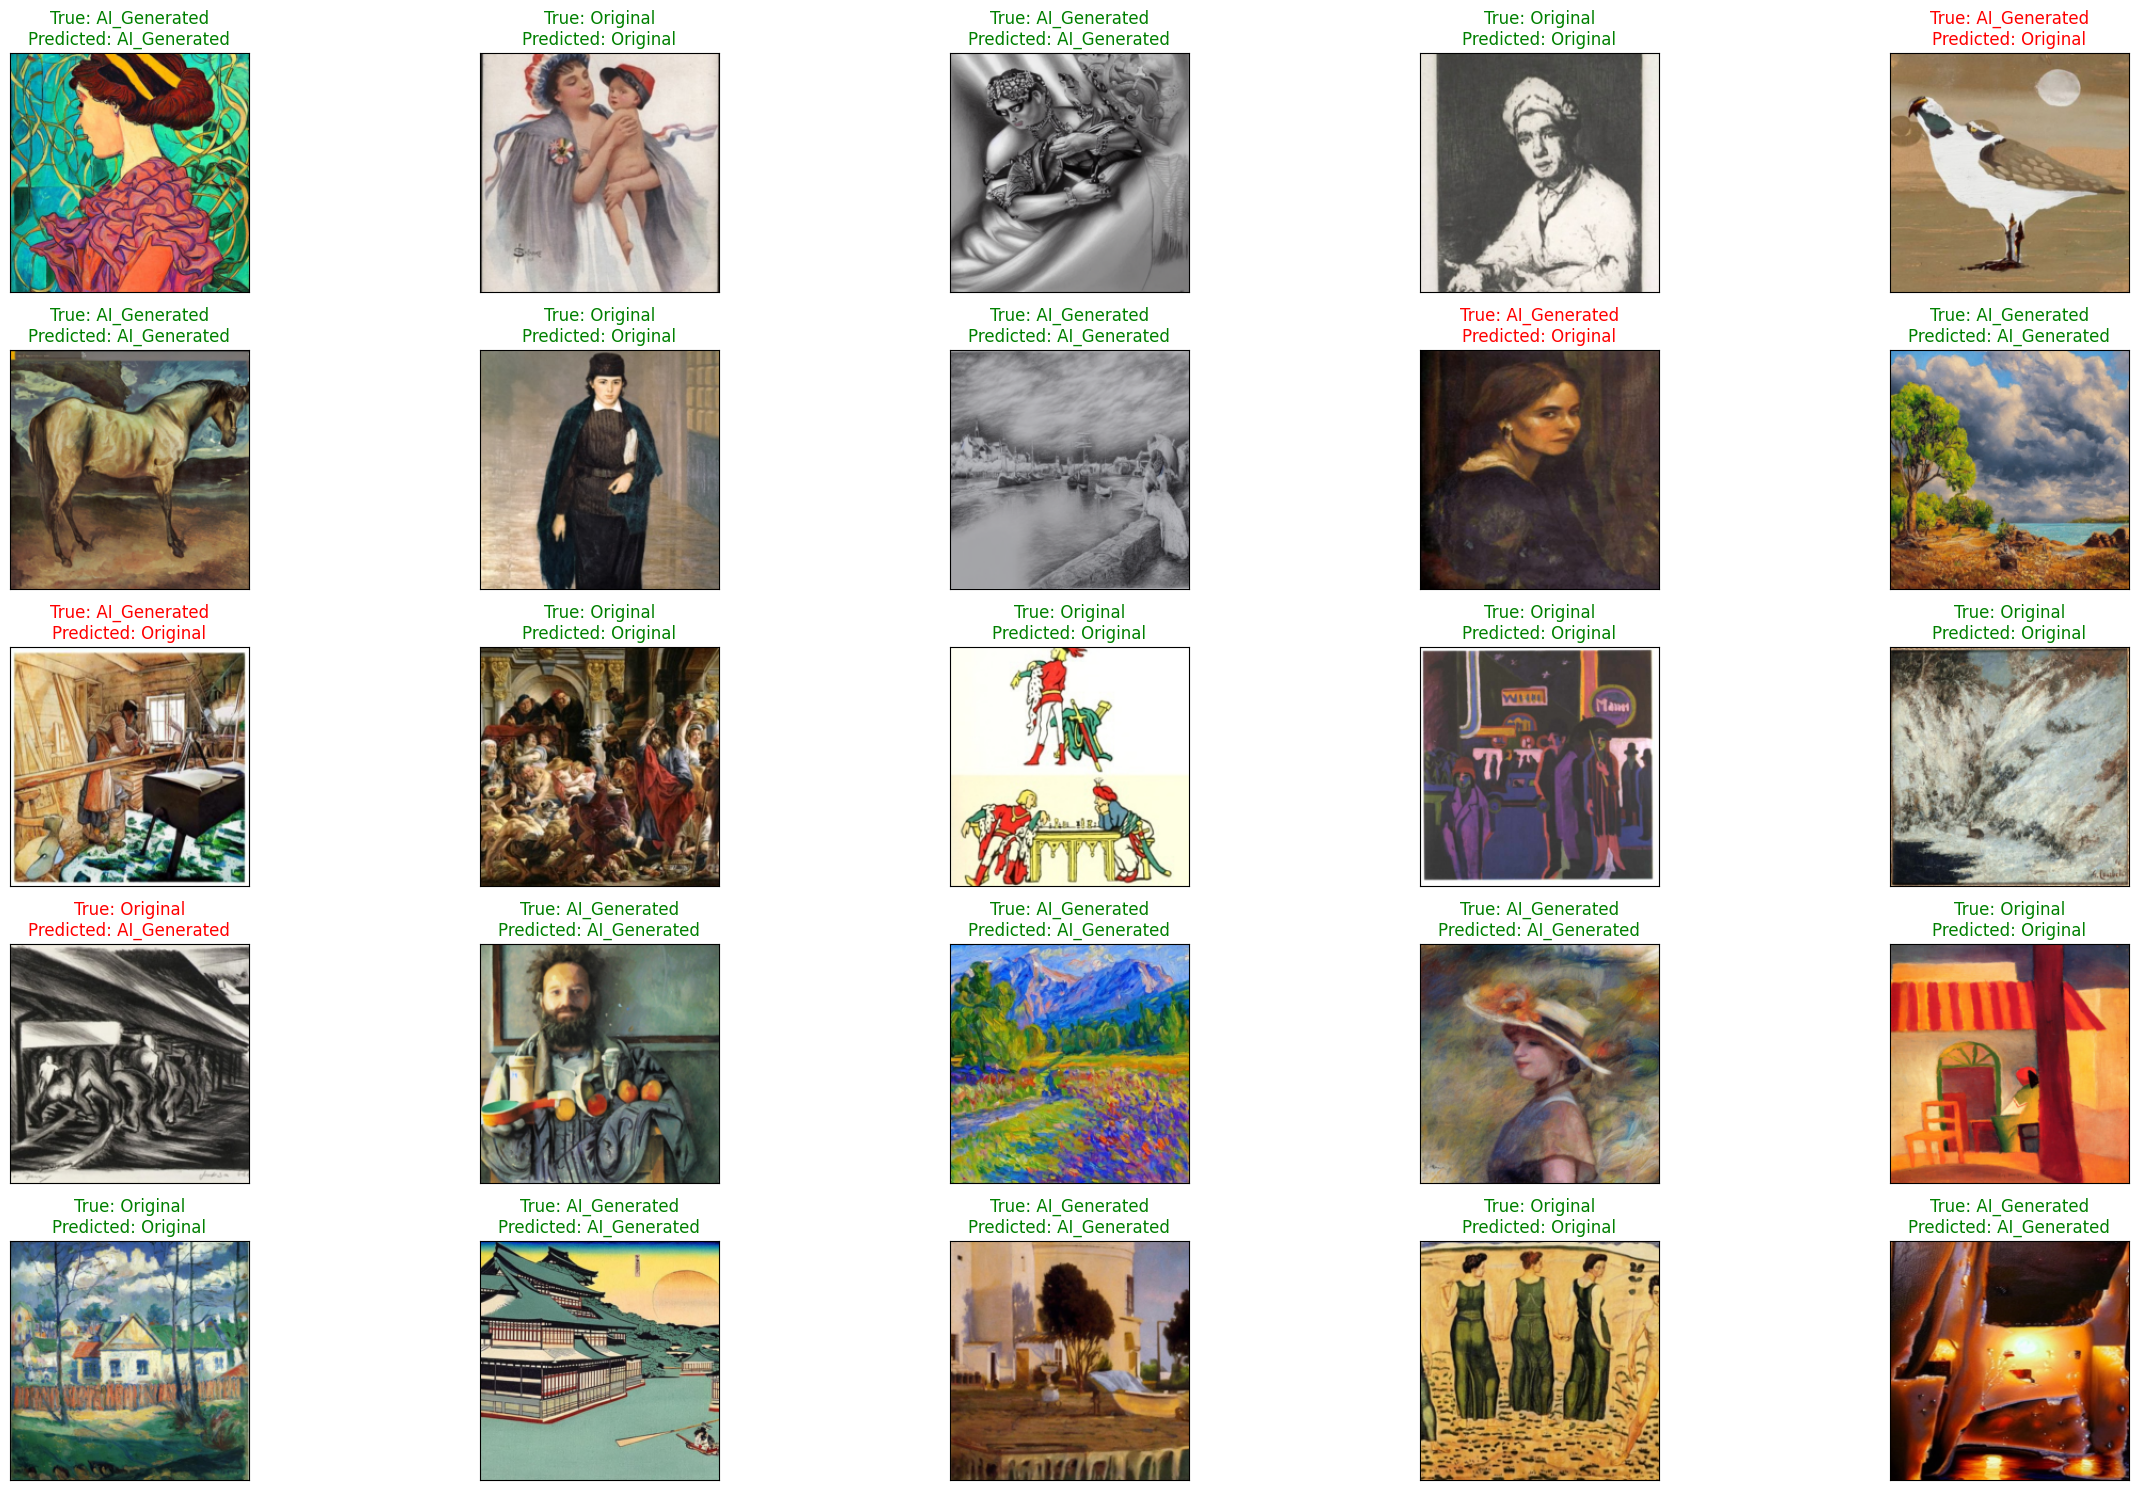

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

class_labels = full_dataset.classes

model.eval()

all_pred_labels = []
all_true_labels = []
all_images = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        if hasattr(outputs, 'logits'):
            outputs = outputs.logits

        _, preds = torch.max(outputs, 1)

        all_pred_labels.extend(preds.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())
        all_images.extend(inputs.cpu())

all_pred_labels = np.array(all_pred_labels)
all_true_labels = np.array(all_true_labels)

num_images_to_display = 25
random_indices = np.random.choice(len(all_images), num_images_to_display, replace=False)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]

    img = all_images[idx].permute(1, 2, 0).numpy()  # Convert from Tensor to NumPy array for plotting
    true_label_idx = all_true_labels[idx]  # Numeric true label
    pred_label_idx = all_pred_labels[idx]  # Numeric predicted label

    true_label = class_labels[true_label_idx]  # Map true label index to class name
    pred_label = class_labels[pred_label_idx]  # Map predicted label index to class name

    ax.imshow(img)

    color = "green" if true_label == pred_label else "red"
    ax.set_title(f"True: {true_label}\nPredicted: {pred_label}", color=color)

plt.tight_layout()
plt.show()